In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
import pandas as pd
import numpy as np
## separando en train, test 
from sklearn.model_selection import train_test_split
## Configuración del RF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [31]:
# predicciones con el mejor predictor 
predicted_labels = gs_rf.predict(X_test)

In [32]:
# predicciones en score con el mejor predictor
predicted_scores = gs_rf.predict_proba(X_test)

In [33]:
predicted_scores[:10]

array([[0.83205586, 0.16794414],
       [0.71612439, 0.28387561],
       [0.8587854 , 0.1412146 ],
       [0.8587854 , 0.1412146 ],
       [0.71612439, 0.28387561],
       [0.71612439, 0.28387561],
       [0.71612439, 0.28387561],
       [0.71612439, 0.28387561],
       [0.8417496 , 0.1582504 ],
       [0.8417496 , 0.1582504 ]])

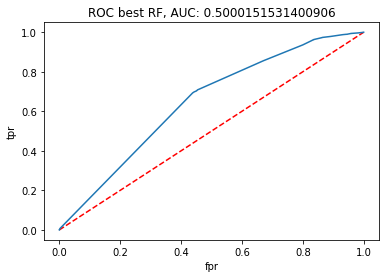

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predicted_labels)

array([[23811,     7],
       [ 6167,     2]])

In [37]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predicted_labels)

0.79411078133858

In [38]:
#### Precision, recall, thresholds
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [39]:
thresholds_2 = np.append(thresholds_2, 1)

In [40]:
(precision.shape, recall.shape, thresholds_2.shape)

((79,), (79,), (79,))

In [41]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [42]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.019837,0.205832,1.000000,0.341395,1.000000,0.999328,0.000672,0.000000
1,0.020973,0.205833,0.999838,0.341386,0.999838,0.999160,0.000840,0.000162
2,0.022548,0.205903,0.999676,0.341473,0.999676,0.998573,0.001427,0.000324
3,0.023237,0.205919,0.999352,0.341476,0.999352,0.998153,0.001847,0.000648
4,0.025895,0.205974,0.999352,0.341551,0.999352,0.997817,0.002183,0.000648
...,...,...,...,...,...,...,...,...
70,0.347880,0.378378,0.002269,0.004512,0.002269,0.000966,0.999034,0.997731
71,0.374324,0.361111,0.002107,0.004190,0.002107,0.000966,0.999034,0.997893
72,0.375214,0.260870,0.000973,0.001938,0.000973,0.000714,0.999286,0.999027
73,0.402596,0.285714,0.000973,0.001939,0.000973,0.000630,0.999370,0.999027


In [43]:
negocio = metrics_report[metrics_report.fpr <= 0.06]
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
69,0.328695,0.457447,0.006970,0.013731,0.006970,0.002141,0.997859,0.993030
70,0.347880,0.378378,0.002269,0.004512,0.002269,0.000966,0.999034,0.997731
71,0.374324,0.361111,0.002107,0.004190,0.002107,0.000966,0.999034,0.997893
72,0.375214,0.260870,0.000973,0.001938,0.000973,0.000714,0.999286,0.999027
73,0.402596,0.285714,0.000973,0.001939,0.000973,0.000630,0.999370,0.999027
74,0.531382,0.222222,0.000324,0.000647,0.000324,0.000294,0.999706,0.999676


In [44]:
punto_corte = negocio.head(1).threshold.values[0]
punto_corte

0.3286946954584606

In [45]:
new_labels = [0 if score < punto_corte else 1 for score in predicted_scores[:,1]]

In [46]:
new_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [47]:
pd.Series(new_labels).sum()

94

In [48]:
confusion_matrix(y_test, new_labels)

array([[23767,    51],
       [ 6126,    43]])

In [49]:
confusion_matrix(y_test, predicted_labels)

array([[23811,     7],
       [ 6167,     2]])

In [1]:
def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return metrics.precision_score(y_true, y_pred)

In [6]:
def recall_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return metrics.recall_score(y_true, y_pred)

In [5]:
def pr_k_curve(y_true, y_scores, save_target):
    k_values = list(np.arange(0.1, 1.1, 0.1))
    pr_k = pd.DataFrame()
    
    for k in k_values:
        d['k'] = k
        ## get_top_k es una función que ordena los scores de
        ## mayor a menor y toma los k% primeros
        top_k = get_top_k(y_scores, k)
        d['precision'] = precision_at_k(top_k)
        d['recall'] = recall_at_k(top_k, predictions)

        pr_k = pr_k.append(d, ignore_index=True)

    # para la gráfica
    fig, ax1 = plt.subplots()
    ax1.plot(pr_k['k'], pr_k['precision'], label='precision')
    ax1.plot(pr_k['k'], pr_k['recall'], label='recall')
    plt.legend()

    if save_target is not None:
        plt.savefig(save_target, dpi=300)

    return pr_k